# Part 3 — Data Quality

## Links
- **Live updated app:** https://ind320-project-work-nonewthing.streamlit.app/
- **Repo:** https://github.com/TaoM29/IND320-dashboard-basics

## Plan for Part 3
1. 

# AI Usage

Used an ChatGPT 5 as a coding and troubleshooting partner. It helped me:

# Work Log

In [35]:
# Necessary imports
from IPython.display import display
import pandas as pd
import requests
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct


In [26]:

# Representative cities for NO1–NO5 and their approximate city-center coordinates
rows = [

    # price_area, city, longitude, latitude
    ("NO1", "Oslo",         10.7461, 59.9127),
    ("NO2", "Kristiansand",  7.9956, 58.1467),
    ("NO3", "Trondheim",    10.3951, 63.4305),
    ("NO4", "Tromsø",       18.9551, 69.6489),
    ("NO5", "Bergen",        5.3242, 60.3930),
    
]

df_price_areas = pd.DataFrame(
    rows, columns=["price_area", "city", "longitude", "latitude"]
)

df_price_areas


,price_area,city,longitude,latitude
0,NO1,Oslo,10.7461,59.9127
1,NO2,Kristiansand,7.9956,58.1467
2,NO3,Trondheim,10.3951,63.4305
3,NO4,Tromsø,18.9551,69.6489
4,NO5,Bergen,5.3242,60.3930


In [32]:
# Columns from Part 1 CSV
_CSV_COLUMNS = [
    "time",
    "temperature_2m (°C)",
    "precipitation (mm)",
    "wind_speed_10m (m/s)",
    "wind_gusts_10m (m/s)",
    "wind_direction_10m (°)",
]

# Map CSV columns -> Open-Meteo ERA5 hourly variable names
_VAR_MAP = {
    "temperature_2m (°C)": "temperature_2m",
    "precipitation (mm)": "precipitation",
    "wind_speed_10m (m/s)": "windspeed_10m",
    "wind_gusts_10m (m/s)": "windgusts_10m",
    "wind_direction_10m (°)": "winddirection_10m",
}


def download_era5_to_df(longitude: float, latitude: float, year: int, timezone: str = "Europe/Oslo") -> pd.DataFrame:
    """
    Download ERA5 historical reanalysis (Open-Meteo archive API) for a single location and year.
    Returns a DataFrame with the SAME columns as our Part 1 CSV.
    """

    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    if year == date.today().year:
        # Ensure we don't request future dates if running mid-year
        end_date = min(end_date, date.today().isoformat())

    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = list(_VAR_MAP.values())

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": hourly_vars,
        "timezone": timezone,
    }

    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()

    # Parse hourly block
    hourly = data.get("hourly", {})
    times = hourly.get("time", [])

    # Build DataFrame with CSV-matching columns/order
    df = pd.DataFrame({"time": pd.to_datetime(times)})

    for csv_col, api_var in _VAR_MAP.items():
        df[csv_col] = hourly.get(api_var, [None] * len(df))

    # Ensure monotonic time index and set dtype
    df = df.sort_values("time").reset_index(drop=True)
    return df


# Apply the function to Bergen for the year 2019.
bergen_2019 = download_era5_to_df(longitude=5.3242, latitude=60.3930, year=2019)

print(f"rows: {len(bergen_2019):}")
display(bergen_2019.head())

rows: 8760


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01 00:00:00,5.7,0.7,37.0,99.7,263
1,2019-01-01 01:00:00,5.8,0.2,41.0,107.3,278
2,2019-01-01 02:00:00,6.1,0.7,42.0,112.0,286
3,2019-01-01 03:00:00,6.3,0.5,40.9,105.8,298
4,2019-01-01 04:00:00,5.8,1.1,41.2,110.2,315


/var/folders/pb/zpm_1bj94yx79fs63fvpltz00000gn/T/ipykernel_11166/3213243766.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(                 time  temperature_2m (°C)      SATV
 0 2019-02-02 14:00:00                 -0.5  6.378833
 1 2019-04-04 12:00:00                 16.4  6.646718
 2 2019-04-04 13:00:00                 16.9  7.026664
 3 2019-04-04 14:00:00                 17.5  7.524481
 4 2019-04-04 15:00:00                 17.4  7.339709,
 {'n_points': 8760,
  'n_outliers': 58,
  'pct_outliers': 0.6621004566210046,
  'dct_low_frac': 0.05,
  'k_sigma': 3.5,
  'satv_median': -0.12235247399478086,
  'satv_robust_sigma': 1.7572549867311327})

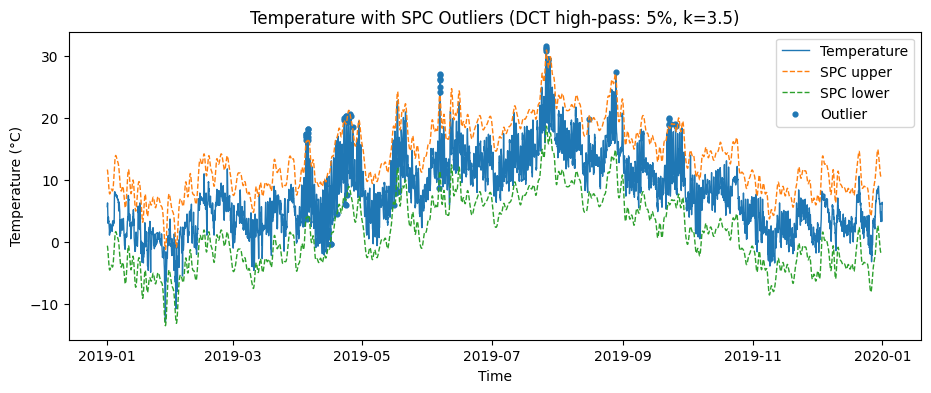

In [ ]:

#     
def plot_temperature_spc_with_dct(
    df: pd.DataFrame,
    time_col: str = "time",
    temp_col: str = "temperature_2m (°C)",
    dct_low_frac: float = 0.05,   # remove the lowest 5% frequencies (trend/seasonality)
    k_sigma: float = 3.5,         # robust "std dev" multiplier for SPC limits
):
    """
    Plots temperature vs time, computes SATV via DCT high-pass, draws SPC bounds,
    and colors outliers. Returns (fig, outliers_df, summary_dict).
    """
    s = df[temp_col].astype(float).to_numpy()
    t = pd.to_datetime(df[time_col])

    # DCT high-pass: remove the lowest-frequency components (including DC) 
    N = s.size
    S = dct(s, type=2, norm="ortho")
    k_cut = max(1, int(np.floor(dct_low_frac * N)))  # number of lowest freqs to zero
    S_hp = S.copy()
    S_hp[:k_cut] = 0.0
    satv = idct(S_hp, type=2, norm="ortho")          # SATV (high-frequency component)
    trend = s - satv                                 # low-frequency (seasonal/trend)

    # Robust statistics on SATV (NOT plot SATV) 
    satv_med = np.median(satv)
    mad = np.median(np.abs(satv - satv_med))
    robust_sigma = 1.4826 * mad if mad > 0 else np.std(satv)  # fallback if flat

    upper_satv = satv_med + k_sigma * robust_sigma
    lower_satv = satv_med - k_sigma * robust_sigma

    # Convert SATV bounds to temperature-scale SPC curves by adding trend
    upper_spc = trend + upper_satv
    lower_spc = trend + lower_satv

    # Outliers where SATV breaches bounds 
    outlier_mask = (satv > upper_satv) | (satv < lower_satv)
    outliers_df = pd.DataFrame({
        time_col: t[outlier_mask].to_numpy(),
        temp_col: s[outlier_mask],
        "SATV": satv[outlier_mask]
    }).sort_values(time_col).reset_index(drop=True)

    # Plot 
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.plot(t, s, linewidth=1.0, label="Temperature")
    ax.plot(t, upper_spc, linestyle="--", linewidth=1.0, label="SPC upper")
    ax.plot(t, lower_spc, linestyle="--", linewidth=1.0, label="SPC lower")
    if outliers_df.shape[0] > 0:
        ax.scatter(outliers_df[time_col], outliers_df[temp_col], s=12, label="Outlier")

    ax.set_title(f"Temperature with SPC Outliers (DCT high-pass: {dct_low_frac:.0%}, k={k_sigma})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend(loc="best")

    # Summary 
    summary = {
        "n_points": int(N),
        "n_outliers": int(outliers_df.shape[0]),
        "pct_outliers": float(100 * outliers_df.shape[0] / max(1, N)),
        "dct_low_frac": float(dct_low_frac),
        "k_sigma": float(k_sigma),
        "satv_median": float(satv_med),
        "satv_robust_sigma": float(robust_sigma),
    }
    return fig, outliers_df, summary


# Usage: Bergen 2019 
fig, outliers_df, summary = plot_temperature_spc_with_dct(bergen_2019)
fig.show()
outliers_df.head(), summary


/opt/miniconda3/envs/IND320env/lib/python3.13/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


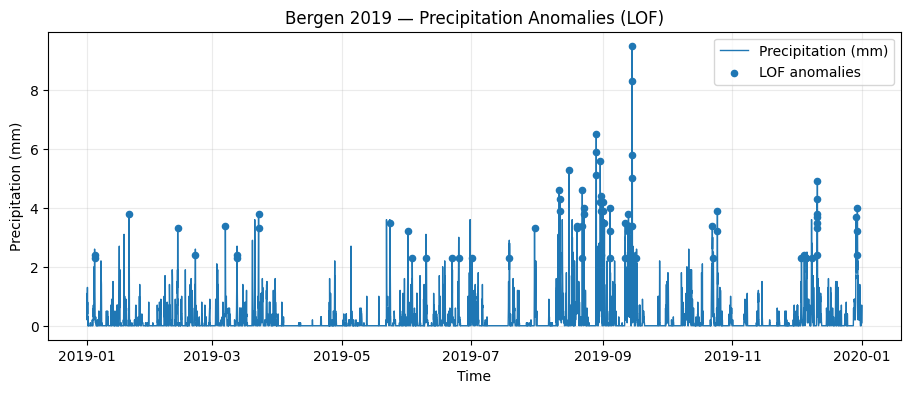

({'n_points': 8760,
  'n_anomalies': 80,
  'anomaly_pct': 0.91324200913242,
  'contamination': 0.01,
  'n_neighbors': 20},
                     time  precipitation (mm)     lof_score
 86   2019-01-04 14:00:00                 2.4  1.000000e+00
 88   2019-01-04 16:00:00                 2.3  1.000000e+08
 477  2019-01-20 21:00:00                 3.8  1.070580e+00
 1026 2019-02-12 18:00:00                 3.3  1.201389e+00
 1227 2019-02-21 03:00:00                 2.4  1.000000e+00)

In [37]:
from sklearn.neighbors import LocalOutlierFactor

def plot_precip_anomalies_lof(
    df: pd.DataFrame,
    time_col: str = "time",
    precip_col: str = "precipitation (mm)",
    contamination: float = 0.01,        # 1% default
    n_neighbors: int = 20,               # typical LOF default
    title: str | None = None
):
    """
    Plot precipitation vs time and highlight anomalies from Local Outlier Factor.
    Returns (fig, summary_dict, anomalies_df).
    """
    s = df[[time_col, precip_col]].dropna().sort_values(time_col)
    t = pd.to_datetime(s[time_col].values)
    y = s[precip_col].astype(float).values.reshape(-1, 1)

    # LOF on univariate precipitation
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )
    y_pred = lof.fit_predict(y)   # -1 = outlier, 1 = inlier
    scores = -lof.negative_outlier_factor_

    is_anom = (y_pred == -1)

    # plot
    fig, ax = plt.subplots(figsize=(11, 4.0))
    ax.plot(t, y[:, 0], lw=1.0, label="Precipitation (mm)")
    ax.scatter(t[is_anom], y[is_anom, 0], s=20, zorder=3, label="LOF anomalies")

    ax.set_xlabel("Time")
    ax.set_ylabel("Precipitation (mm)")
    ax.set_title(title or f"Precipitation Anomalies (LOF, contamination={contamination:.2%})")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.25)

    anomalies_df = s.loc[is_anom, [time_col, precip_col]].copy()
    anomalies_df["lof_score"] = scores[is_anom]

    summary = {
        "n_points": int(len(s)),
        "n_anomalies": int(is_anom.sum()),
        "anomaly_pct": float(is_anom.mean() * 100),
        "contamination": float(contamination),
        "n_neighbors": int(n_neighbors),
    }

    return fig, summary, anomalies_df


fig_p, summary_p, anomalies_p = plot_precip_anomalies_lof(
    bergen_2019,
    time_col="time",
    precip_col="precipitation (mm)",
    contamination=0.01,        # per our spec
    n_neighbors=20,
    title="Bergen 2019 — Precipitation Anomalies (LOF)"
)
plt.show()

summary_p, anomalies_p.head()
